# Import Libraries

In [2]:
from __future__ import print_function
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
best_acc1 = 0
tmp_best_acc1 = 0

### Optimum values found for L1-penalty-weight & L2-weight-decay
    - The appropriate values for l1 & l2 related weights were found after coarsely sweeping thru values from 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001 first.
    - For l1-weight, with l1-alone enabled, the 0.00001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.00001 region, led to the value: 0.000025, which seems to be having best accuracy values.
    - Similarly, For l2-weight,  with l2-alone enabled, the 0.0001 region was found with better values for the validation accuracy vis-a-vis training accuracies.
    - Much finer sweeping in the 0.0001 region, led to the value: 0.0002125, which seems to be having best accuracy values.
    - For individual models, either or both of them will be enabled/disbaled using some related flags defined ahead in this notebook
    - Please note, L2 regaularization implementation is in-built with torch. 

In [4]:
l1_weight = 0.000025 ##Appears to be the best with the reference NW we have used here
l2_weight_decay = 0.0002125 ##Appears to be the best with the reference NW we have used here

In [5]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [6]:
class_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

##  Dataset and Creating Train/Test Split & Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [7]:
# load the training data
cifar10_train = datasets.CIFAR10('./data', train=True, download=True)
# use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(cifar10_train[i][0]) for i in range(len(cifar10_train))])
# print(x)
print(x.shape)
# calculate the mean and std along the (0, 1) axes
train_mean = np.mean(x, axis=(0, 1))/255
train_std = np.std(x, axis=(0, 1))/255
# the the mean and std
print(train_mean, train_std)

Files already downloaded and verified
(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
                                       ])

In [9]:
train_cifar10 = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_cifar10 = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
test_cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Dataloader Arguments & Test/Train Dataloaders


In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_cifar10, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_cifar10, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


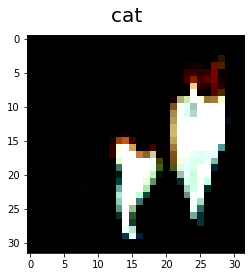

In [15]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = torch.from_numpy(train_cifar10.data)
print('[Train]')
print(' - Numpy Shape:', torch.from_numpy(train_cifar10.data).cpu().numpy().shape)
print(' - Tensor Shape:', torch.from_numpy(train_cifar10.data).size())
print(' - min:', torch.min(torch.from_numpy(train_cifar10.data)))
print(' - max:', torch.max(torch.from_numpy(train_cifar10.data)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
img_number = np.random.randint(images.shape[0])
plt.figure().suptitle('{} '.format(class_names[labels[img_number]]), fontsize=20)
_= plt.imshow(images.numpy().squeeze()[img_number,::].transpose((1,2,0)), interpolation='nearest')

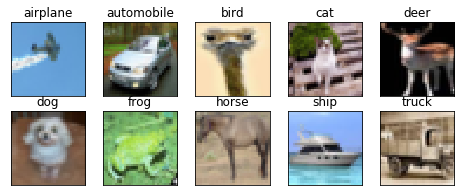

In [16]:
num_classes = len(np.unique(train_cifar10.targets))
num_classes
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(np.array(train_cifar10.targets)[:]==i)[0]
    features_idx = train_loader.dataset.data[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Training and Testing related routines

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [17]:
def l1_penalty(x):
    #L1 regularization adds an L1 penalty equal
    #to the absolute value of the magnitude of coefficients
    return torch.abs(x).sum()

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train(model, device, train_loader, optimizer, epoch, L1=False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        if L1:
            to_reg = []
            for param in model.parameters():
                to_reg.append(param.view(-1))
            l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        else:
            l1 = 0
        # Calculate loss
        #L1 regularization adds an L1 penalty equal to the 
        #absolute value of the magnitude of coefficients
        loss = F.nll_loss(y_pred, target) + l1 #torch.nn.CrossEntropyLoss:criterion combines
                                               #nn.LogSoftmax() and nn.NLLLoss() in one single class.    
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader, epoch):
    global best_acc1, tmp_best_acc1
    model.eval()
    test_loss = 0
    correct = 0
    acc1 = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    acc1 = 100. * correct / len(test_loader.dataset)
    is_best = acc1 > best_acc1
    tmp_best_acc1 = best_acc1
    best_acc1 = max(acc1, best_acc1)
    # Prepare model model saving directory.
    if is_best:
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = 'CIFAR10_model_epoch-{}_L1-{}_L2-{}_val_acc-{}.h5'.format(epoch+1, int(L1), int(L2), acc1) 
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        print("validation-accuracy improved from {} to {}, saving model to {}".format(tmp_best_acc1, best_acc1, filepath))
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename=filepath)
    test_acc.append(100. * correct / len(test_loader.dataset))

### model-prediction & mislabelled image display related routines


In [18]:
test_cifar10.data.shape[0]

10000

In [ ]:
!pip uninstall scikit-learn


In [1]:
from sklearn.metrics import confusion_matrix, classification_report

ImportError: cannot import name 'confusion_matrix'

In [19]:
def model_pred(model, device, y_test, batchsize=100):
    from sklearn.metrics import confusion_matrix, classification_report
    start = 0
    stop = batchsize
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=4, pin_memory=True) if cuda else dict(shuffle=False, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_cifar10, **dataldr_args)
    y_pred = np.zeros((y_test.shape[0], 1))
    with torch.no_grad():
        for data, target in test_ldr:
            batch_nums = np.arange(start, stop)
            data, target = data.to(device), target.to(device)
            output = model(data)
            y_pred[batch_nums]  = output.argmax(dim=1, keepdim=True).cpu().numpy() 
            start +=batchsize
            stop  +=batchsize
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    return y_pred


def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(55,10))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(class_names[int(i)]) + ' Pred:{} '.format(class_names[int(y_pred[intsct[img_num]][0])]), fontsize=24)
            plt.imshow(im)
    plt.show()

### routine to load any model from saved file

In [20]:
def load_model(describe_model_nn, model_name):
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    model = describe_model_nn #describe_model_nn is for example: Net1()
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.to(device)
    return  model

### routine to save & load the validation-accuracy & validation-loss data  for any model

In [21]:
def save_acc_loss(test_losses, test_acc, test_loss_file_name,  test_acc_file_name):
    import os
    import numpy as np
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    np.save(filepath_test_loss,test_losses)
    np.save(filepath_test_acc,test_acc)
    

def load_acc_loss(test_loss_file_name,  test_acc_file_name):
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_data')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath_test_loss  = os.path.join(save_dir, test_loss_file_name)
    filepath_test_acc  = os.path.join(save_dir, test_acc_file_name)
    loaded_test_losses = np.load(filepath_test_loss).tolist()
    loaded_test_acc = np.load(filepath_test_acc).tolist()
    return loaded_test_losses, loaded_test_acc

### routine to plot 4 accuracies and 4 losses in 2 separate plots

In [22]:
def plot_curves(first_acc, second_acc, third_acc, fourth_acc,
                first_loss, second_loss, third_loss, fourth_loss):
    fig, axs = plt.subplots(1,2,figsize=(20,10))
    _= axs[0].plot(first_acc)
    _= axs[0].plot(second_acc)
    _= axs[0].plot(third_acc)
    _= axs[0].plot(fourth_acc)
    _= axs[0].set_title('model test accuracies', fontsize=22)
    _= axs[0].set_ylabel('test-accuracy', fontsize=18)
    _= axs[0].set_xlabel('epoch', fontsize=18)
    _= axs[0].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper left')
    _= axs[1].plot(first_loss)
    _= axs[1].plot(second_loss)
    _= axs[1].plot(third_loss)
    _= axs[1].plot(fourth_loss)
    _= axs[1].set_title('model test losses', fontsize=22)
    _= axs[1].set_ylabel('test-loss', fontsize=18)
    _= axs[1].set_xlabel('epoch', fontsize=18)
    _= axs[1].legend(['without L1 & L2', 'with L1 alone', 'with L2 alone', 'with both L1 & L2'], loc='upper right')

# The model
Let's start with the model we first saw, the base-line/refernce model being used here is as shown in the table below:
Please note that my earlier assignment's 5th model had a learning rate-step-LR based change in learning rate, to enter a crevice of higher accuracy within 15 epochs.The same if used as a baseline will have this extra LR as a variable.The effects of L1 & L2 penalties would not be obvious for that earlier NW, hence am starting out with the 3rd Stable NW from assignment-5


![alt text](model_dgm.png "Title")

# 1. model,  40 epochs, with L1 alone

In [23]:
L1 = True #without L1-penalty 
L2 = False #without L2-penalty

In [24]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation=dilation,groups=in_channels,bias=bias),
            nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias),
        )
    def forward(self,x):
        x = self.convblock(x)
        return x

In [25]:
dropout_value = 0.05
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # C1 Block
        self.convblock1 = nn.Sequential(
            SeparableConv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3
        self.convblock2 = nn.Sequential(
            SeparableConv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, bias=False, dilation=2),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # C2 Block
        self.convblock4 = nn.Sequential(
            SeparableConv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        
        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        
        # C3 Block
        self.convblock6 = nn.Sequential(
            SeparableConv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        
        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6  
        
        # C4 Block
        self.convblock8 = nn.Sequential(
            SeparableConv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # C1 Block
        x = self.convblock1(x)
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # C2 Block
        x = self.convblock4(x)
        # TRANSITION BLOCK 2
        x = self.pool2(x)
        x = self.convblock5(x)
        # C3 Block
        x = self.convblock6(x)
        # TRANSITION BLOCK 3
        x = self.pool3(x)
        x = self.convblock7(x)
        # C4 Block
        x = self.convblock8(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock9(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1) #the torch.nn.CrossEntropyLoss, criterion combines
                                        #nn.LogSoftmax() and nn.NLLLoss() in one single class.

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [26]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model1 = Net1().to(device)
summary(model1, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 64, 32, 32]             192
   SeparableConv2d-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]             576
            Conv2d-8          [-1, 128, 32, 32]           8,192
   SeparableConv2d-9          [-1, 128, 32, 32]               0
      BatchNorm2d-10          [-1, 128, 32, 32]             256
          Dropout-11          [-1, 128, 32, 32]               0
             ReLU-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
           Conv2d-14           [-1

# Let's Train and test our model

In [21]:
model1 =  Net1().to(device)
#Enable L2-regularization with supplied value of weight decay, or keep it default-0
if L2:
    weight_decay = l2_weight_decay
else:
    weight_decay = 0    
    
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=weight_decay)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader, epoch)

EPOCH: 1


Loss=0.9716601967811584 Batch_id=781 Accuracy=46.20: 100%|███████████████████████████| 782/782 [00:39<00:00, 20.02it/s]



Test set: Average loss: 1.3070, Accuracy: 5345/10000 (53.45%)

validation-accuracy improved from 0 to 53.45, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-1_L1-1_L2-0_val_acc-53.45.h5
EPOCH: 2


Loss=1.3412349224090576 Batch_id=781 Accuracy=61.69: 100%|███████████████████████████| 782/782 [00:39<00:00, 20.00it/s]



Test set: Average loss: 1.1244, Accuracy: 6018/10000 (60.18%)

validation-accuracy improved from 53.45 to 60.18, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-2_L1-1_L2-0_val_acc-60.18.h5
EPOCH: 3


Loss=1.0065510272979736 Batch_id=781 Accuracy=67.21: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.99it/s]



Test set: Average loss: 0.9458, Accuracy: 6657/10000 (66.57%)

validation-accuracy improved from 60.18 to 66.57, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-3_L1-1_L2-0_val_acc-66.57.h5
EPOCH: 4


Loss=0.4409160912036896 Batch_id=781 Accuracy=70.33: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.78it/s]



Test set: Average loss: 0.8602, Accuracy: 7040/10000 (70.40%)

validation-accuracy improved from 66.57 to 70.4, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-4_L1-1_L2-0_val_acc-70.4.h5
EPOCH: 5


Loss=0.524391770362854 Batch_id=781 Accuracy=72.73: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.95it/s]



Test set: Average loss: 0.7616, Accuracy: 7330/10000 (73.30%)

validation-accuracy improved from 70.4 to 73.3, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-5_L1-1_L2-0_val_acc-73.3.h5
EPOCH: 6


Loss=0.5638612508773804 Batch_id=781 Accuracy=74.69: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.78it/s]



Test set: Average loss: 0.7749, Accuracy: 7274/10000 (72.74%)

EPOCH: 7


Loss=0.4855955243110657 Batch_id=781 Accuracy=76.15: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.79it/s]



Test set: Average loss: 0.8081, Accuracy: 7194/10000 (71.94%)

EPOCH: 8


Loss=0.5581735968589783 Batch_id=781 Accuracy=77.43: 100%|███████████████████████████| 782/782 [00:39<00:00, 20.00it/s]



Test set: Average loss: 0.7667, Accuracy: 7334/10000 (73.34%)

validation-accuracy improved from 73.3 to 73.34, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-8_L1-1_L2-0_val_acc-73.34.h5
EPOCH: 9


Loss=0.5147180557250977 Batch_id=781 Accuracy=78.21: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.99it/s]



Test set: Average loss: 0.6752, Accuracy: 7691/10000 (76.91%)

validation-accuracy improved from 73.34 to 76.91, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-9_L1-1_L2-0_val_acc-76.91.h5
EPOCH: 10


Loss=0.8015247583389282 Batch_id=781 Accuracy=79.06: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.99it/s]



Test set: Average loss: 0.6631, Accuracy: 7727/10000 (77.27%)

validation-accuracy improved from 76.91 to 77.27, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-10_L1-1_L2-0_val_acc-77.27.h5
EPOCH: 11


Loss=0.7235488295555115 Batch_id=781 Accuracy=79.60: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.93it/s]



Test set: Average loss: 0.6799, Accuracy: 7635/10000 (76.35%)

EPOCH: 12


Loss=0.7278296947479248 Batch_id=781 Accuracy=80.31: 100%|███████████████████████████| 782/782 [00:40<00:00, 19.54it/s]



Test set: Average loss: 0.6477, Accuracy: 7775/10000 (77.75%)

validation-accuracy improved from 77.27 to 77.75, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-12_L1-1_L2-0_val_acc-77.75.h5
EPOCH: 13


Loss=0.8402858376502991 Batch_id=781 Accuracy=80.87: 100%|███████████████████████████| 782/782 [00:42<00:00, 18.23it/s]



Test set: Average loss: 0.6721, Accuracy: 7674/10000 (76.74%)

EPOCH: 14


Loss=0.4658941924571991 Batch_id=781 Accuracy=81.27: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.97it/s]



Test set: Average loss: 0.6301, Accuracy: 7800/10000 (78.00%)

validation-accuracy improved from 77.75 to 78.0, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-14_L1-1_L2-0_val_acc-78.0.h5
EPOCH: 15


Loss=0.36543208360671997 Batch_id=781 Accuracy=81.83: 100%|██████████████████████████| 782/782 [00:39<00:00, 20.00it/s]



Test set: Average loss: 0.6987, Accuracy: 7584/10000 (75.84%)

EPOCH: 16


Loss=0.2142392098903656 Batch_id=781 Accuracy=81.95: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.94it/s]



Test set: Average loss: 0.6727, Accuracy: 7740/10000 (77.40%)

EPOCH: 17


Loss=0.4537639021873474 Batch_id=781 Accuracy=82.73: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.95it/s]



Test set: Average loss: 0.7033, Accuracy: 7661/10000 (76.61%)

EPOCH: 18


Loss=0.5358160734176636 Batch_id=781 Accuracy=82.92: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.86it/s]



Test set: Average loss: 0.5811, Accuracy: 7983/10000 (79.83%)

validation-accuracy improved from 78.0 to 79.83, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-18_L1-1_L2-0_val_acc-79.83.h5
EPOCH: 19


Loss=0.3986873924732208 Batch_id=781 Accuracy=83.45: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.78it/s]



Test set: Average loss: 0.5961, Accuracy: 7940/10000 (79.40%)

EPOCH: 20


Loss=1.1048436164855957 Batch_id=781 Accuracy=83.58: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.84it/s]



Test set: Average loss: 0.6449, Accuracy: 7857/10000 (78.57%)

EPOCH: 21


Loss=0.512848973274231 Batch_id=781 Accuracy=83.86: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.88it/s]



Test set: Average loss: 0.6092, Accuracy: 7913/10000 (79.13%)

EPOCH: 22


Loss=0.41277021169662476 Batch_id=781 Accuracy=84.21: 100%|██████████████████████████| 782/782 [00:39<00:00, 19.92it/s]



Test set: Average loss: 0.5937, Accuracy: 7988/10000 (79.88%)

validation-accuracy improved from 79.83 to 79.88, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-22_L1-1_L2-0_val_acc-79.88.h5
EPOCH: 23


Loss=0.35014504194259644 Batch_id=781 Accuracy=84.58: 100%|██████████████████████████| 782/782 [00:39<00:00, 19.82it/s]



Test set: Average loss: 0.6252, Accuracy: 7883/10000 (78.83%)

EPOCH: 24


Loss=0.343058705329895 Batch_id=781 Accuracy=84.77: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.83it/s]



Test set: Average loss: 0.5764, Accuracy: 8083/10000 (80.83%)

validation-accuracy improved from 79.88 to 80.83, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-24_L1-1_L2-0_val_acc-80.83.h5
EPOCH: 25


Loss=0.3980933129787445 Batch_id=781 Accuracy=84.78: 100%|███████████████████████████| 782/782 [00:40<00:00, 19.55it/s]



Test set: Average loss: 0.5948, Accuracy: 7981/10000 (79.81%)

EPOCH: 26


Loss=0.9966412782669067 Batch_id=781 Accuracy=85.47: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.78it/s]



Test set: Average loss: 0.6166, Accuracy: 7919/10000 (79.19%)

EPOCH: 27


Loss=1.188391089439392 Batch_id=781 Accuracy=85.31: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.86it/s]



Test set: Average loss: 0.5922, Accuracy: 8006/10000 (80.06%)

EPOCH: 28


Loss=0.35659366846084595 Batch_id=781 Accuracy=85.63: 100%|██████████████████████████| 782/782 [00:39<00:00, 19.91it/s]



Test set: Average loss: 0.5783, Accuracy: 8063/10000 (80.63%)

EPOCH: 29


Loss=0.6107515096664429 Batch_id=781 Accuracy=86.10: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.77it/s]



Test set: Average loss: 0.6197, Accuracy: 7921/10000 (79.21%)

EPOCH: 30


Loss=0.483569860458374 Batch_id=781 Accuracy=85.95: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.75it/s]



Test set: Average loss: 0.5927, Accuracy: 8008/10000 (80.08%)

EPOCH: 31


Loss=0.7053028345108032 Batch_id=781 Accuracy=86.07: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.95it/s]



Test set: Average loss: 0.5860, Accuracy: 8067/10000 (80.67%)

EPOCH: 32


Loss=0.474185973405838 Batch_id=781 Accuracy=86.68: 100%|████████████████████████████| 782/782 [00:39<00:00, 19.95it/s]



Test set: Average loss: 0.5967, Accuracy: 8008/10000 (80.08%)

EPOCH: 33


Loss=0.6773715615272522 Batch_id=781 Accuracy=86.54: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.97it/s]



Test set: Average loss: 0.5843, Accuracy: 8053/10000 (80.53%)

EPOCH: 34


Loss=0.7049911618232727 Batch_id=781 Accuracy=86.65: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.91it/s]



Test set: Average loss: 0.5671, Accuracy: 8076/10000 (80.76%)

EPOCH: 35


Loss=0.5176164507865906 Batch_id=781 Accuracy=86.62: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.72it/s]



Test set: Average loss: 0.5957, Accuracy: 8031/10000 (80.31%)

EPOCH: 36


Loss=0.3645068109035492 Batch_id=781 Accuracy=87.00: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.79it/s]



Test set: Average loss: 0.6017, Accuracy: 8009/10000 (80.09%)

EPOCH: 37


Loss=1.0083394050598145 Batch_id=781 Accuracy=87.02: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.93it/s]



Test set: Average loss: 0.5681, Accuracy: 8115/10000 (81.15%)

validation-accuracy improved from 80.83 to 81.15, saving model to D:\PG-ML\eva4\week7\saved_models\CIFAR10_model_epoch-37_L1-1_L2-0_val_acc-81.15.h5
EPOCH: 38


Loss=0.5425737500190735 Batch_id=781 Accuracy=87.20: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.93it/s]



Test set: Average loss: 0.5932, Accuracy: 8075/10000 (80.75%)

EPOCH: 39


Loss=0.3140729069709778 Batch_id=781 Accuracy=87.59: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.91it/s]



Test set: Average loss: 0.6103, Accuracy: 7999/10000 (79.99%)

EPOCH: 40


Loss=0.8436259031295776 Batch_id=781 Accuracy=87.28: 100%|███████████████████████████| 782/782 [00:39<00:00, 19.89it/s]



Test set: Average loss: 0.6315, Accuracy: 7942/10000 (79.42%)



Text(0.5, 1.0, 'Test Accuracy')

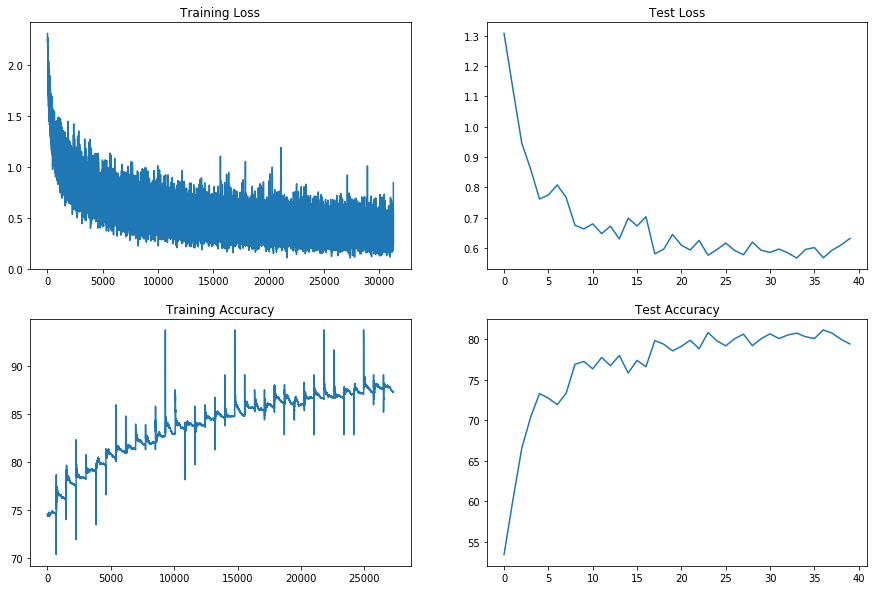

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### save the validation-accuracy & validation-loss data  for the  model with L1 alone

In [46]:
save_acc_loss(test_losses, 
              test_acc, 
              test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
              test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
             )

### an example load for the validation-accuracy & validation-loss data  for the  model with L1 alone
        - Once having saved as a file, these acc/loss values can be loaded anytime

In [24]:
#Load these data points later using code as below
test_loss_l1_0_l2_0, test_acc_l1_0_l2_0 = load_acc_loss(
                                                         test_loss_file_name='test_loss_l1_{}_l2_{}.npy'.format(int(L1), int(L2)),
                                                         test_acc_file_name='test_acc_l1_{}_l2_{}.npy'.format(int(L1), int(L2))
                                                         )

Text(0.5, 1.0, 'Test Loss')

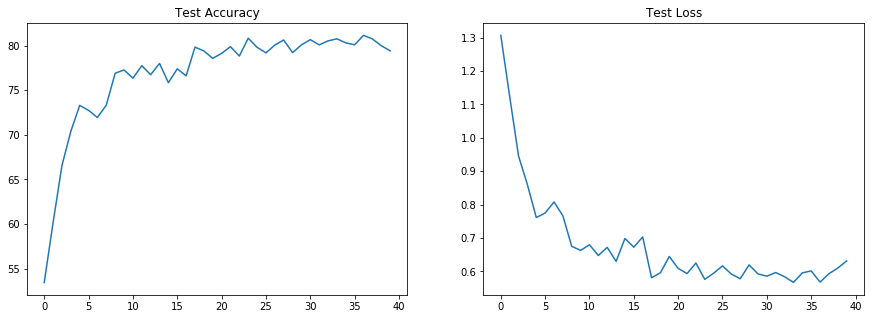

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(test_acc_l1_0_l2_0)
axs[0].set_title("Test Accuracy")
axs[1].plot(test_loss_l1_0_l2_0)
axs[1].set_title("Test Loss")

### an example load of  the  model with L1 alone
        - Once having saved as a file, these best model can be loaded anytime, by giving the name

In [22]:
model = load_model(Net1(), model_name='CIFAR10_model_epoch-37_L1-1_L2-0_val_acc-81.15.h5')

### confusion matrix & classification-report for this model prdection
        - load the best model as above and get the predictions

In [23]:
y_test = np.array(test_cifar10.targets)
y_pred  = model_pred(model, device, y_test)

[[860   5  34  14  11   4  11  13  30  18]
 [ 15 885   0   5   1   5  17  10  21  41]
 [ 51   1 703  28  55  48  72  36   3   3]
 [ 17   2  43 623  42 163  69  39   0   2]
 [ 11   1  29  35 786  30  55  48   5   0]
 [ 10   2  23 102  29 774  19  41   0   0]
 [  3   1  13  38  19  17 896  11   1   1]
 [ 15   0  14  20  30  44   3 873   0   1]
 [ 65  13  14  18   5   1   9   5 859  11]
 [ 28  49   6  17   3   3   7  15  16 856]]
              precision    recall  f1-score   support

    airplane       0.80      0.86      0.83      1000
  automobile       0.92      0.89      0.90      1000
        bird       0.80      0.70      0.75      1000
         cat       0.69      0.62      0.66      1000
        deer       0.80      0.79      0.79      1000
         dog       0.71      0.77      0.74      1000
        frog       0.77      0.90      0.83      1000
       horse       0.80      0.87      0.84      1000
        ship       0.92      0.86      0.89      1000
       truck       0.92     

### mislabelled images from the model with L1 alone
        - load the best model as above and get the predictions

In [ ]:
x_test = test_mnist.test_data.cpu().numpy()

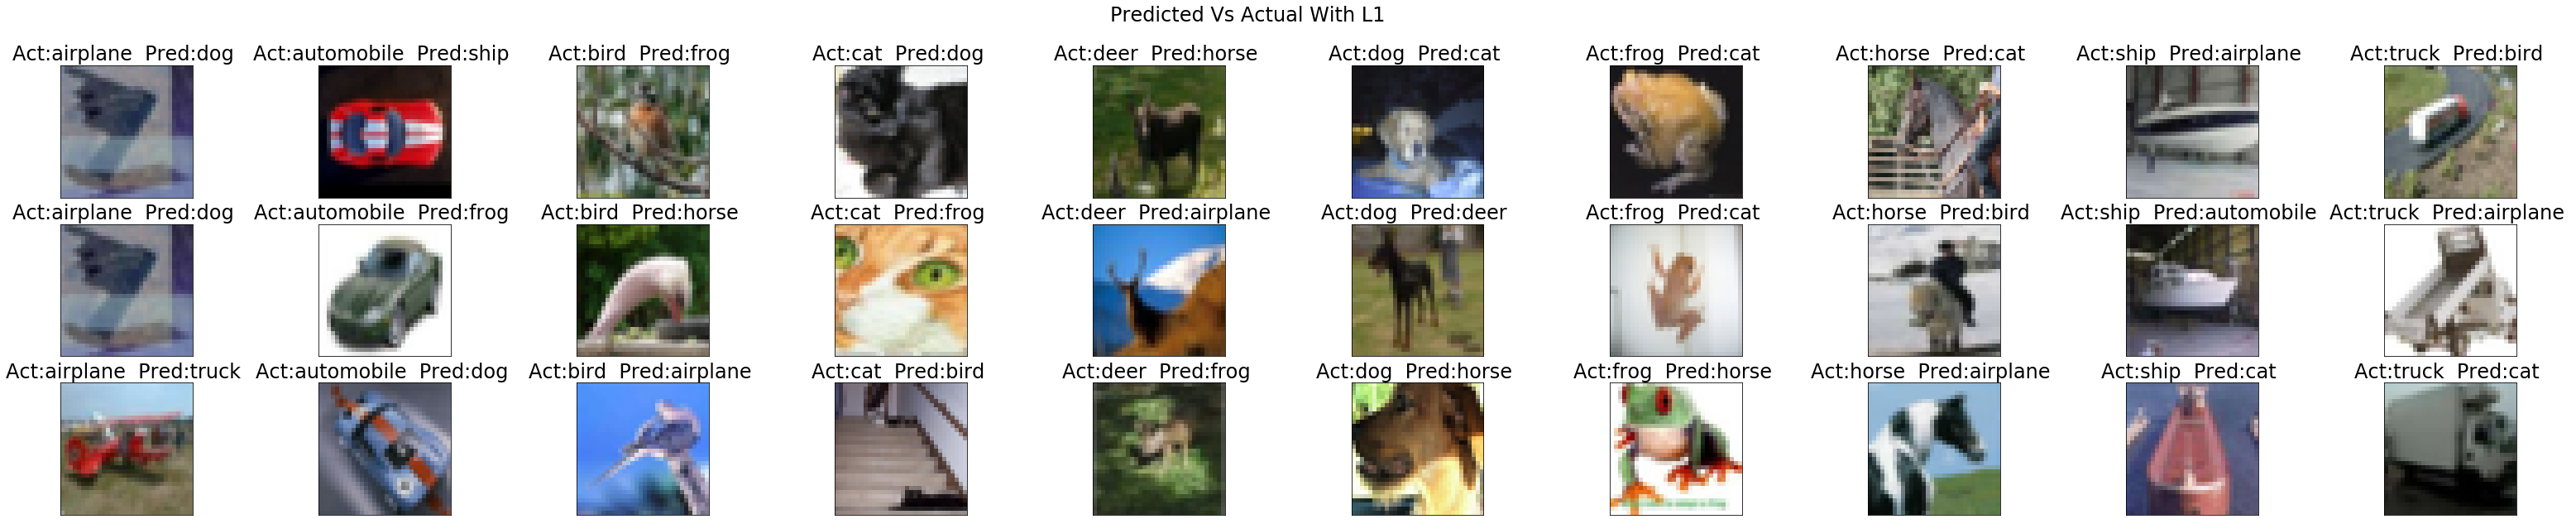

In [45]:
x_test = test_cifar10.data
display_mislabelled(model, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With L1' )